## Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor, cv, Pool

from collections import defaultdict

from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

import shap
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline

from tqdm import tqdm

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor, cv, Pool

from collections import defaultdict

from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

import shap
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline

from tqdm import tqdm
import random
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED) # Seed 고정

# 한글 폰트 설정
from statsmodels import robust
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

# 데이터 불러오기

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
X_train = train.drop(['ID','착과량(int)'], axis=1)
y_train = train['착과량(int)']

# 파생변수 + Smogn

In [6]:
#파생변수 생성
ft=train.iloc[:,6:95].agg(['min','max','mean','std'],axis=1)
ft_e=test.iloc[:,5:94].agg(['min','max','mean','std'],axis=1)
train=pd.concat([train,ft],axis=1)
test=pd.concat([test,ft_e],axis=1)

ft=train.iloc[:,95:184].agg(['min','max','mean','std'],axis=1)
ft_e=test.iloc[:,94:183].agg(['min','max','mean','std'],axis=1)
ft.columns=['min_g','max_g',"mean_g","std_g"]
ft_e.columns=['min_g','max_g',"mean_g","std_g"]
train=pd.concat([train,ft],axis=1)
test=pd.concat([test,ft_e],axis=1)

train.drop('ID',axis=1,inplace=True)


In [7]:
import smogn

In [8]:
# Data oversampling
# 데이터셋이 적어 학습이 부족하다 생각함.

## specify phi relevance values
rg_mtrx = [

    [100,  1, 0],  ## over-sample ("minority")
    [200, 0, 1],  ## under-sample ("majority")
    [500, 0, 1],  ## under-sample
    [1000, 1, 0],  ## under-sample
]
     

In [9]:
0.726
## conduct smogn
X_s = smogn.smoter(
    
    ## main arguments
    data = train,           ## pandas dataframe
    y = '착과량(int)',          ## string ('header name')
    k = 7,                    ## positive integer (k < n)
    pert = 0.04,              ## real number (0 < R < 1)
    samp_method = 'balance',  ## string ('balance' or 'extreme')
    drop_na_col = True,       ## boolean (True or False)
    drop_na_row = True,       ## boolean (True or False)
    replace = False,          ## boolean (True or False)

    ## phi relevance argument
    rel_thres = 0.10,         ## real number (0 < R < 1)
    rel_method = 'manual',    ## string ('auto' or 'manual')
    #rel_xtrm_type = 'both', ## unused (rel_method = 'manual')
    # rel_coef = 1.50,        ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx ## 2d array (format: [x, y])
)
     

r_index: 100%|##########| 197/197 [00:02<00:00, 72.45it/s]


<AxesSubplot:xlabel='착과량(int)', ylabel='Density'>

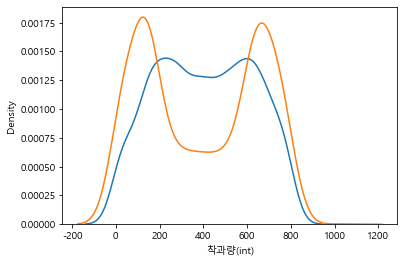

In [10]:
import seaborn
## distribution plot
seaborn.kdeplot(train['착과량(int)'], label = "Original")
seaborn.kdeplot(X_s['착과량(int)'], label = "Modified")

# PCA (사용X)
pca 사용시 검증시 성능이 더 떨어져 사용 x

In [9]:
f=train.iloc[:,6:95]
t=train.iloc[:,95:184]

green_list=list(t.columns)
sae_list=list(f.columns)
mul_list=[]
for i in range(f.shape[1]):
    
    mul=f[sae_list[i]]*t[green_list[i]]
    mul_list.append(mul)
    
f_t=test.iloc[:,5:94]
t_t=test.iloc[:,94:183]

green_list_t=list(t_t.columns)
sae_list_t=list(f_t.columns)
mul_list_t=[]
for i in range(f_t.shape[1]):
    
    mul_t=f_t[sae_list_t[i]]*t_t[green_list_t[i]]
    mul_list_t.append(mul_t)

In [10]:
df=pd.DataFrame(mul_list).T
df_t=pd.DataFrame(mul_list_t).T

<AxesSubplot:xlabel='착과량(int)', ylabel='Density'>

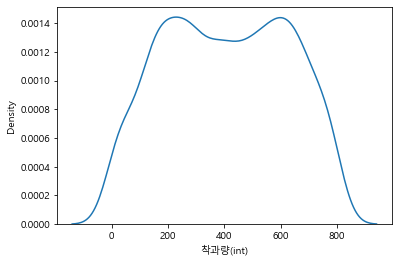

In [27]:
import seaborn
## distribution plot
#seaborn.kdeplot(train['착과량(int)'], label = "Original")
seaborn.kdeplot(X_s['착과량(int)'], label = "Modified")

In [196]:
train_x=pd.concat([train,X_s],axis=0)
train_x=train_x.reset_index(drop=True)
train_x=train_x.reset_index()

In [13]:
x = df.values 
x_t = df_t.values 

In [9]:
from sklearn.decomposition import PCA
#불필요한 변수가 많아 pca 진행
#3번 4번 성분은 0.04정도로 설명 가능한 분산량이 얼마 증가하지 않기 때문에,
#주성분은 2개로 결정하는 것이 적절하다.
#점점 작아지도록 정렬되어 있음을 알 수 있다.

pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
print(pca.explained_variance_ratio_)
#x_t=scaler.transform(x_t)
printcipalComponents_t = pca.transform(x_t)
principalDf_t = pd.DataFrame(data=printcipalComponents_t, columns = ['principal component1', 'principal component2'])
print(pca.explained_variance_ratio_)

[0.98169988 0.01112019]
[0.98169988 0.01112019]


In [10]:
train=pd.concat([train,principalDf],axis=1)
test=pd.concat([test,principalDf_t],axis=1)

In [11]:
x=train.iloc[:,95:184].values
x_t=test.iloc[:,94:183].values

from sklearn.decomposition import PCA
#3번 4번 성분은 0.04정도로 설명 가능한 분산량이 얼마 증가하지 않기 때문에,
#주성분은 2개로 결정하는 것이 적절하다.
#점점 작아지도록 정렬되어 있음을 알 수 있다.
#scaler=StandardScaler()
#x = scaler.fit_transform(x)

pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['green component1', 'green component2'])
print(pca.explained_variance_ratio_)
#x_t=scaler.transform(x_t)
printcipalComponents_t = pca.transform(x_t)
principalDf_t = pd.DataFrame(data=printcipalComponents_t, columns = ['green component1', 'green component2'])
print(pca.explained_variance_ratio_)

[0.9970539  0.00179381]
[0.9970539  0.00179381]


In [12]:
train=pd.concat([train,principalDf],axis=1)
test=pd.concat([test,principalDf_t],axis=1)

In [13]:
drop_list=list(train.iloc[:,95:184].columns)

train=train.drop(drop_list,axis=1)
test=test.drop(drop_list,axis=1)

In [14]:
train.shape,test.shape

((2207, 107), (2208, 106))

# Feature selection
여러가지 알고리즘으로 Feature selection 진행

In [85]:
#bourtashap
bourta_list_train=['ID','착과량(int)','2022-09-03 새순', '2022-09-01 새순', '2022-09-11 새순', '2022-09-16 새순', 'principal component1', '2022-09-05 새순', '2022-09-04 새순', '2022-09-06 새순', 'max', '2022-09-09 새순', '2022-09-02 새순', '2022-09-25 새순', '2022-09-07 새순', '2022-09-20 새순', 'green component2', 'std', '2022-09-17 새순', '2022-09-13 새순', '2022-09-10 새순']
bourta_list_test=['ID','2022-09-03 새순', '2022-09-01 새순', '2022-09-11 새순', '2022-09-16 새순', 'principal component1', '2022-09-05 새순', '2022-09-04 새순', '2022-09-06 새순', 'max', '2022-09-09 새순', '2022-09-02 새순', '2022-09-25 새순', '2022-09-07 새순', '2022-09-20 새순', 'green component2', 'std', '2022-09-17 새순', '2022-09-13 새순', '2022-09-10 새순']

#percenttile (ngboost)
feature_list_train=['ID','착과량(int)','2022-09-01 새순', '2022-09-02 새순', '2022-09-03 새순', '2022-09-05 새순', '2022-09-06 새순']
feature_list_test=['ID','2022-09-01 새순', '2022-09-02 새순', '2022-09-03 새순', '2022-09-05 새순', '2022-09-06 새순']

#percenttile (ridge)
ridge_train=['index','착과량(int)','2022-09-01 새순', '2022-09-02 새순', '2022-09-03 새순', '2022-09-04 새순', '2022-09-05 새순', '2022-09-06 새순', '2022-09-07 새순', '2022-09-08 새순', '2022-09-09 새순', '2022-09-10 새순', '2022-09-11 새순', '2022-09-12 새순', '2022-09-13 새순', '2022-09-14 새순', '2022-09-15 새순', '2022-09-16 새순', '2022-09-17 새순', '2022-09-20 새순', '2022-09-21 새순', 'max', 'std']
ridge_test=['ID','2022-09-01 새순', '2022-09-02 새순', '2022-09-03 새순', '2022-09-04 새순', '2022-09-05 새순', '2022-09-06 새순', '2022-09-07 새순', '2022-09-08 새순', '2022-09-09 새순', '2022-09-10 새순', '2022-09-11 새순', '2022-09-12 새순', '2022-09-13 새순', '2022-09-14 새순', '2022-09-15 새순', '2022-09-16 새순', '2022-09-17 새순', '2022-09-20 새순', '2022-09-21 새순', 'max', 'std']

In [197]:
shap_list=list(features_selected)
shap_list.append('index')
shap_list.append('착과량(int)')
shap_test=list(features_selected)
shap_test.append('ID')

In [198]:
train_x=train_x[shap_list]
#train=train[feature_list_train]
test=test[shap_test]

# 데이터 전처리 코드

In [ ]:
class DataProcessor(object):
    def __init__(self):
        self.encoder = None
        self.standard_scaler = None
        self.num_cols = None
        self.cat_cols = None
        
    def preprocess(self, data_df, train=True, one_hot_encode=False,
                   combine_min_cats=False, add_pca_feats=False):
        """ Preprocess train / test as required """
        
        # if training, fit our transformers
        if train:
            self.train_ids = data_df.loc[:, 'index']
            data_df=data_df.drop('index',axis=1)
            train_cats = data_df.loc[:, data_df.dtypes == object]
            self.cat_cols = train_cats.columns
            
            # if selected, combine minority categorical feats
            if combine_min_cats:
                self._find_minority_cats(train_cats)
                train_cats = self._combine_minority_feats(train_cats)
            
            # if selected, one hot encode our cat features
            if one_hot_encode:
                self.encoder = OneHotEncoder(handle_unknown='ignore')
                oh_enc = self.encoder.fit_transform(train_cats).toarray()
                train_cats_enc = pd.DataFrame(oh_enc, columns=self.encoder.get_feature_names_out(), 
                                              dtype=np.int64)
                self.final_cat_cols = list(train_cats_enc.columns)
            
            # otherwise just encode our cat feats with ints
            else:
                # encode all of our categorical variables
                self.encoder = defaultdict(LabelEncoder)
                train_cats_enc = train_cats.apply(lambda x: 
                                                  self.encoder[x.name].fit_transform(x))
                self.final_cat_cols = list(self.cat_cols)
            
            
            # standardise all numerical columns
            train_num = data_df.loc[:, data_df.dtypes != object].drop(columns=['착과량(int)'])
            self.num_cols = train_num.columns
            self.standard_scaler = StandardScaler()
            train_num_std = self.standard_scaler.fit_transform(train_num)
            
            # add pca reduced num feats if selected, else just combine num + cat feats
            if add_pca_feats:
                pca_feats = self._return_num_pca(train_num_std)
                self.final_num_feats = list(self.num_cols)+list(self.pca_cols)
                
                
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            else:   
                self.final_num_feats = list(self.num_cols)
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols))
        
        # otherwise, treat as test data
        else:
            # transform categorical and numerical data
            self.test_ids = data_df.loc[:, 'ID']
            cat_data = data_df.loc[:, self.cat_cols]
            if combine_min_cats:
                cat_data = self._combine_minority_feats(cat_data)
        
            if one_hot_encode:
                oh_enc = self.encoder.transform(cat_data).toarray()
                cats_enc = pd.DataFrame(oh_enc, 
                                        columns=self.encoder.get_feature_names_out(), 
                                        dtype=np.int64)
            else:
                cats_enc = cat_data.apply(lambda x: self.encoder[x.name].transform(x))
                
            # transform test numerical data
            num_data = data_df.loc[:, self.num_cols]
            num_std = self.standard_scaler.transform(num_data)
            
            if add_pca_feats:
                pca_feats = self._return_num_pca(num_std, train=False)
                
                X = pd.DataFrame(np.hstack((cats_enc, num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            
            else:
                X = pd.DataFrame(np.hstack((cats_enc, num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)) 
        return X
    
    
    def _find_minority_cats(self, data_df, composite_category='z', threshold=0.05):
        """ Find minority categories for each feature column, and create a 
            dictionary that maps those to selected composite category """
        self.min_col_dict = {}
        self.min_cat_mappings = {}
    
        # find all feature categories with less than 5% proportion
        for feature in self.cat_cols:
            self.min_col_dict[feature] = []
            self.min_cat_mappings[feature] = {}
        
            for category, proportion in data_df[feature].value_counts(normalize=True).iteritems():
                if proportion < threshold:
                    self.min_col_dict[feature].append(category)
                
                    # map those minority cats to chosen composite feature
                    self.min_cat_mappings[feature] = {x : composite_category for x 
                                                    in self.min_col_dict[feature]}
    
    
    def _combine_minority_feats(self, data_df, replace=False):
        """ Combine minority categories into composite for each cat feature """
        new_df = data_df.copy()
        for feat in self.cat_cols:
            col_label = f"{feat}" if replace else f"{feat}_new"
            new_df[feat] = new_df[feat].replace(self.min_cat_mappings[feat])
        return new_df
    
    
    def _return_num_pca(self, num_df, n_components=0.95, train=True):
        """ return dim reduced numerical features using PCA """
        if train:
            self.pca = PCA(n_components=n_components)
            num_rd = self.pca.fit_transform(num_df)
            
            # create new col names for our reduced features
            self.pca_cols = [f"pca_{x}" for x in range(num_rd.shape[1])]
            
        else:
            num_rd = self.pca.transform(num_df)
        
        return pd.DataFrame(num_rd, columns=self.pca_cols)

In [199]:
PCA_FEATS = True
ONE_HOT_ENCODE = True

data_proc = DataProcessor()
X = data_proc.preprocess(train_x,  one_hot_encode=ONE_HOT_ENCODE)
y = train_x.loc[:, '착과량(int)']
X_test = data_proc.preprocess(test, train=False, one_hot_encode=ONE_HOT_ENCODE)

print(f"X: {X.shape} \ny: {y.shape} \nX_test: {X_test.shape}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} \nX_val: {X_val.shape}, \ny_val: {y_val.shape}")

_, X_sub, _, y_sub = train_test_split(X, y, test_size=0.05)
X_sub.shape, y_sub.shape

X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_sub, y_sub, test_size=0.2)
X_train_sub.shape, X_val_sub.shape, y_train_sub.shape, y_val_sub.shape

X: (4190, 30) 
y: (4190,) 
X_test: (2208, 30)
X_train: (3352, 30) 
y_train: (3352,) 
X_val: (838, 30), 
y_val: (838,)


((168, 30), (42, 30), (168,), (42,))

# Feature selection 알고리즘
여기서 알고리즘끼리 A/B TEST를 거친 뒤 가장 성능이 좋게 나온은 알고리즘의 Feature list 채택 (shap)

100%|██████████| 95/95 [00:16<00:00,  5.89it/s]

(11, -34.31977456710967)


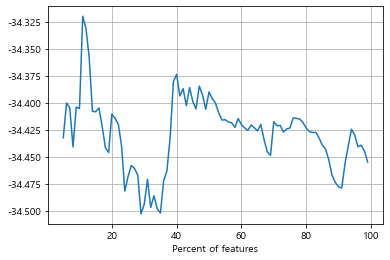

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import SelectPercentile
from lightgbm import LGBMRegressor

# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = Ridge(random_state=2022)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []

sscv = ShuffleSplit(n_splits = 5, random_state = 0)

for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X, y)    
    cv_score = cross_val_score(model, X_new, y, scoring='neg_mean_absolute_error', cv=sscv).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [17]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X, y)
X_train_select = fs.transform(X)
X_test_select = fs.transform(X_test)

In [18]:
XX_train_nothuman=X.copy()
XX_test_nothuman=X_test.copy()

In [19]:
print(X_train_select.shape)
print(XX_train_nothuman.columns[fs.get_support()].tolist()) #get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(4190, 21)
['2022-09-01 새순', '2022-09-02 새순', '2022-09-03 새순', '2022-09-04 새순', '2022-09-05 새순', '2022-09-06 새순', '2022-09-07 새순', '2022-09-08 새순', '2022-09-09 새순', '2022-09-10 새순', '2022-09-11 새순', '2022-09-12 새순', '2022-09-13 새순', '2022-09-14 새순', '2022-09-15 새순', '2022-09-16 새순', '2022-09-17 새순', '2022-09-20 새순', '2022-09-21 새순', 'max', 'std']


In [21]:
X=pd.DataFrame(X_train_select,columns=XX_train_nothuman.columns[fs.get_support()])
X_test=pd.DataFrame(X_test_select,columns=XX_train_nothuman.columns[fs.get_support()])

In [22]:
cat_feat_dtype_dict = { x : "int" for x in data_proc.final_cat_cols}
X = X.astype(cat_feat_dtype_dict)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} \nX_val: {X_val.shape}, \ny_val: {y_val.shape}")

_, X_sub, _, y_sub = train_test_split(X, y, test_size=0.05)
X_sub.shape, y_sub.shape

X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_sub, y_sub, test_size=0.2)
X_train_sub.shape, X_val_sub.shape, y_train_sub.shape, y_val_sub.shape

X_train: (3352, 21) 
y_train: (3352,) 
X_val: (838, 21), 
y_val: (838,)


((168, 21), (42, 21), (168,), (42,))

In [189]:
import shap

# Method 2: Using SHAP values
#IDtrain = X_train['custid']
#x_train = x_train
#X_test = test

# DF, based on which importance is checked
X_importance = X_train

# Explain model predictions using shap library:
model = LGBMRegressor(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
#shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
# bestscore feature 23개 1.3 or 1.5 둘중하나임
features_selected = importance_df.query('shap_importance > 0.9').column_name
#X_train = X_train[features_selected]
#X_test = X_test[features_selected]
print(len(features_selected))
print(X_train.shape)

30
(3352, 190)


# 모델링

In [ ]:
#NAME 평가지표 정의
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

# 첫번째 모델 Catboost optuna
사용 X Catboost는 너무 많은 하이퍼파라미터 튜닝을 진행하면 성능이 오히려 하락함 (automl 활용이 좋음)

In [18]:
import catboost as cb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [19]:
from optuna import Trial
from optuna.samplers import TPESampler
# random sampler
sampler = TPESampler(seed=10)

# define function
def objective(trial):

    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 4000, 25000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
    }

    # Generate model
    model_cbrm = CatBoostRegressor(**cbrm_param)
    model_cbrm = model_cbrm.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                           verbose=0, early_stopping_rounds=25)
                           
	# 평가지표 원하는 평가 지표가 있을 시 바꾸어 준다.
    NMAE = np.mean(np.abs(y_val-model_cbrm.predict(X_val))) / np.mean(np.abs(y_val))
    return NMAE

optuna_cbrm = optuna.create_study(direction='minimize', sampler=sampler)
optuna_cbrm.optimize(objective, n_trials=50)

[I 2022-12-13 21:37:02,774] A new study created in memory with name: no-name-8d6d3e8f-e088-421e-8778-f4c1f1ded198
[I 2022-12-13 21:37:03,293] Trial 0 finished with value: 0.07520922440817751 and parameters: {'iterations': 20198, 'od_wait': 537, 'learning_rate': 0.6373117525770127, 'reg_lambda': 74.88039076582236, 'subsample': 0.4985070123025904, 'random_strength': 18.991865821233908, 'depth': 3, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.022561047334047252, 'colsample_bylevel': 0.8112158910206784}. Best is trial 0 with value: 0.07520922440817751.
[I 2022-12-13 21:37:03,632] Trial 1 finished with value: 0.07443094290424211 and parameters: {'iterations': 24022, 'od_wait': 507, 'learning_rate': 0.5170703407519188, 'reg_lambda': 81.26209803900173, 'subsample': 0.6125260668293881, 'random_strength': 38.87021269727198, 'depth': 5, 'min_data_in_leaf': 28, 'leaf_estimation_iterations': 11, 'bagging_temperature': 1.4797129411694714, 'colsample_bylevel': 0.

[I 2022-12-13 21:37:44,576] Trial 17 finished with value: 0.07406655931094949 and parameters: {'iterations': 16858, 'od_wait': 1318, 'learning_rate': 0.105324795639096, 'reg_lambda': 33.515492034731665, 'subsample': 0.7112904388840094, 'random_strength': 25.33927328925479, 'depth': 13, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 15, 'bagging_temperature': 17.680016161656038, 'colsample_bylevel': 0.8913221783922484}. Best is trial 3 with value: 0.0725605520050895.
[I 2022-12-13 21:37:45,195] Trial 18 finished with value: 0.07465418210713899 and parameters: {'iterations': 6997, 'od_wait': 1168, 'learning_rate': 0.3049006945217591, 'reg_lambda': 52.99706919101871, 'subsample': 0.6864911062329981, 'random_strength': 10.687770092073453, 'depth': 11, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 8, 'bagging_temperature': 2.823194507774439, 'colsample_bylevel': 0.987095928877787}. Best is trial 3 with value: 0.0725605520050895.
[I 2022-12-13 21:37:45,865] Trial 19 finished w

[I 2022-12-13 21:37:53,606] Trial 34 finished with value: 0.07474011215187097 and parameters: {'iterations': 12360, 'od_wait': 517, 'learning_rate': 0.6269295103279126, 'reg_lambda': 16.1832496076837, 'subsample': 0.5589798906947815, 'random_strength': 16.90491334210916, 'depth': 6, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 14, 'bagging_temperature': 48.049855136987084, 'colsample_bylevel': 0.7881361209159347}. Best is trial 3 with value: 0.0725605520050895.
[I 2022-12-13 21:37:54,147] Trial 35 finished with value: 0.0742973205263422 and parameters: {'iterations': 14412, 'od_wait': 850, 'learning_rate': 0.5407645148577441, 'reg_lambda': 26.83706579607714, 'subsample': 0.7544640658619298, 'random_strength': 29.732895485897192, 'depth': 5, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 10, 'bagging_temperature': 4.538896638915958, 'colsample_bylevel': 0.6680616581909454}. Best is trial 3 with value: 0.0725605520050895.
[I 2022-12-13 21:37:54,657] Trial 36 finished with

In [20]:
cbrm_trial = optuna_cbrm.best_trial
cbrm_trial_params = cbrm_trial.params
print('Best Trial: score {},\nparams {}'.format(cbrm_trial.value, cbrm_trial_params))

Best Trial: score 0.0725605520050895,
params {'iterations': 10704, 'od_wait': 662, 'learning_rate': 0.3076930560698413, 'reg_lambda': 11.398445046511357, 'subsample': 0.8286813263076767, 'random_strength': 11.87585277556999, 'depth': 10, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.06248706964153717, 'colsample_bylevel': 0.91411018147464}


In [123]:
**cbrm_trial_params

{'iterations': 11723,
 'od_wait': 1238,
 'learning_rate': 0.9593124701495419,
 'reg_lambda': 42.0549634999815,
 'subsample': 0.8372220014265316,
 'random_strength': 20.05222863570296,
 'depth': 10,
 'min_data_in_leaf': 25,
 'leaf_estimation_iterations': 14,
 'bagging_temperature': 2.7985178715258745,
 'colsample_bylevel': 0.9606907423536728}

In [97]:
class HPOptimiser(object):
    """ Class to optimiser hyper-parameters using hyperopt on a given
        set of training and validation inputs and labels """

    def __init__(self, X_train, X_val, y_train, y_val):
        self.X_train = X_train
        self.X_val  = X_val
        self.y_train = y_train
        self.y_val  = y_val

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def catboost_reg(self, para):
        reg = CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, params):
        reg.fit(self.X_train, self.y_train,
                eval_set=[(self.X_train, self.y_train), (self.X_val, self.y_val)],
                **params['fit_params'])
        pred = reg.predict(self.X_val)
        loss = params['loss_func'](self.y_val, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [98]:
obj = HPOptimiser(X_train_sub, X_val_sub, y_train_sub, y_val_sub)

catboost_opt = obj.process(fn_name='catboost_reg', space=catboost_params, 
                          trials=Trials(), algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [01:08<00:00,  1.46trial/s, best loss: 0.3509258815961556]


In [99]:
catboost_opt

({'colsample_bylevel': 0, 'learning_rate': 2, 'max_depth': 4},
 <hyperopt.base.Trials at 0x2934c302700>)

In [21]:
cb_learn_rate = 0.006
n_iterations = 80000
early_stop_rounds = 400

opt_catboost_params = {'iterations' : n_iterations,
                       'learning_rate' : cb_learn_rate,
                       'depth': 7,
                       'bootstrap_type' : 'Bernoulli',
                       'random_strength': 1,
                       'min_data_in_leaf': 10,
                       'l2_leaf_reg': 3,
                       'loss_function' : 'MAE', 
                       'eval_metric' : 'MAE',
                       'grow_policy' : 'Depthwise',
                       'max_bin' : 1024, 
                       'model_size_reg' : 0,
                       'task_type' : 'GPU',
                       'od_type' : 'IncToDec',
                       'od_wait' : 100,
                       'metric_period' : 500,
                       'verbose' : 500,
                       'subsample' : 0.8,
                       'od_pval' : 1e-10,
                       'max_ctr_complexity' : 8,
                       'has_time': False,
                       'simple_ctr' : 'FeatureFreq',
                       'combinations_ctr': 'FeatureFreq',
                       'random_seed' : 13}

In [ ]:
cb_reg = CatBoostRegressor(**opt_catboost_params)

cb_reg.fit(X_train, y_train, eval_set=(X_val, y_val), 
           use_best_model=True, plot=False, 
           early_stopping_rounds=early_stop_rounds)

0:	learn: 189.0177762	test: 184.4771811	best: 184.4771811 (0)	total: 8.06ms	remaining: 10m 44s


In [42]:
val_preds = cb_reg.predict(X_val)

# calculate mean squared error on val sub-set preds
NMAE(val_preds, y_val)

0.12613017830508472

In [43]:
def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                  title="Residual Plot", figsize=(9,6), xlim=[6.5, 9.5]):
    """ Residual plot to evaluate performance of our simple linear regressor """
    plt.figure(figsize=figsize)
    plt.scatter(train_preds, train_preds - train_labels, c='blue', alpha=0.1,
                marker='o', edgecolors='white', label='Training')
    
    if test_labels is not None:
        plt.scatter(test_preds, test_preds - test_labels, c='red', alpha=0.1,
                    marker='^', edgecolors='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.hlines(y=0, xmin=xlim[0], xmax=xlim[1], color='black', lw=2)
    plt.xlim(xlim)
    if test_labels is not None:
        plt.legend(loc='best')
    plt.title(title)
    plt.show()
    return

In [51]:
feat_importances = cb_reg.get_feature_importance(prettified=True)
feat_importances

,Feature Id,Importances
0,2022-09-02 새순,34.841868
1,2022-09-07 새순,17.272898
2,2022-09-04 새순,14.372671
3,2022-09-05 새순,13.214975
4,2022-09-06 새순,2.941221
...,...,...
179,2022-09-27 새순,0.002091
180,2022-11-13 엽록소,0.002008
181,2022-11-03 새순,0.001904
182,2022-10-14 엽록소,0.001881


Text(0.5, 1.0, 'CatBoost features importance:')

Glyph 49352 missing from current font.
Glyph 49692 missing from current font.
Glyph 49688 missing from current font.
Glyph 44256 missing from current font.
Glyph 44288 missing from current font.
Glyph 54253 missing from current font.
Glyph 49352 missing from current font.
Glyph 49692 missing from current font.
Glyph 49688 missing from current font.
Glyph 44256 missing from current font.
Glyph 44288 missing from current font.
Glyph 54253 missing from current font.


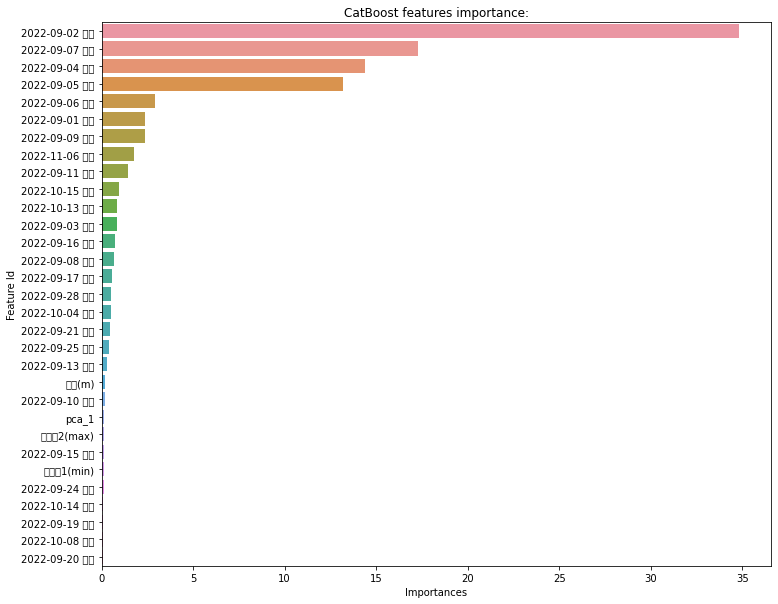

In [52]:
plt.figure(figsize=(12, 10))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:30, :])
plt.title('CatBoost features importance:')

# 두번째 모델 catboost kfold
사용 X 데이터가 적어 FOLD로 나누면 성능이 더떨어지는 현상 발생

In [36]:
N_FOLDS = 5
k_folds = KFold(n_splits=N_FOLDS, shuffle=True)

# convert y values into appropriate form
y_array = y.values.reshape(-1, 1)

In [37]:
early_stop_rounds = 400

model_nmae = []
test_preds = np.zeros((X_test.shape[0], 1))

for train_idx, val_idx in tqdm(k_folds.split(X, y)):
    train_split = X.iloc[train_idx].copy()
    train_labels = y.iloc[train_idx].astype(np.float64).copy()
    val_split = X.iloc[val_idx].copy()
    val_labels = y.iloc[val_idx].astype(np.float64).copy()
    
    temp_model = CatBoostRegressor(random_state = SEED)
    
    # train model for 100 epochs with early stopping
    temp_model.fit(train_split, train_labels, 
               eval_set=(val_split, val_labels), 
               use_best_model=True,
               early_stopping_rounds=early_stop_rounds)
    
    # find log loss for out of fold val data
    model_val_preds = temp_model.predict(val_split)
    
    # calculate mean squared error on val sub-set preds
    fold_nmae = NMAE(model_val_preds, val_labels)
    model_nmae.append(fold_nmae)
    print(f'Current Fold validation nmae: {fold_nmae:.4f}')
    
    # make predictions on test set for each fold
    temp_test_preds = temp_model.predict(X_test).reshape(-1, 1)
    test_preds += (temp_test_preds / N_FOLDS)

# convert results to np array
model_nmae = np.array(model_nmae)

0it [00:00, ?it/s]

Learning rate set to 0.051301
0:	learn: 208.9373600	test: 207.5747085	best: 207.5747085 (0)	total: 9.03ms	remaining: 9.02s
1:	learn: 199.1219719	test: 197.6007657	best: 197.6007657 (1)	total: 10.7ms	remaining: 5.33s
2:	learn: 189.8603316	test: 188.4289887	best: 188.4289887 (2)	total: 12.2ms	remaining: 4.05s
3:	learn: 181.1536003	test: 179.5733704	best: 179.5733704 (3)	total: 13.6ms	remaining: 3.39s
4:	learn: 172.6979702	test: 171.2248058	best: 171.2248058 (4)	total: 15ms	remaining: 2.98s
5:	learn: 164.7962369	test: 163.2083521	best: 163.2083521 (5)	total: 16.4ms	remaining: 2.71s
6:	learn: 157.2880872	test: 155.6096297	best: 155.6096297 (6)	total: 17.7ms	remaining: 2.51s
7:	learn: 150.1519285	test: 148.4718796	best: 148.4718796 (7)	total: 19.2ms	remaining: 2.38s
8:	learn: 143.5535308	test: 141.8735833	best: 141.8735833 (8)	total: 20.7ms	remaining: 2.28s
9:	learn: 137.0646268	test: 135.2731130	best: 135.2731130 (9)	total: 22.2ms	remaining: 2.2s
10:	learn: 130.9728693	test: 129.1260701	be

99:	learn: 37.5565155	test: 36.5931501	best: 36.5931501 (99)	total: 148ms	remaining: 1.33s
100:	learn: 37.5350766	test: 36.5630304	best: 36.5630304 (100)	total: 150ms	remaining: 1.33s
101:	learn: 37.5234091	test: 36.5484462	best: 36.5484462 (101)	total: 151ms	remaining: 1.33s
102:	learn: 37.5058486	test: 36.5480414	best: 36.5480414 (102)	total: 152ms	remaining: 1.33s
103:	learn: 37.4989528	test: 36.5472214	best: 36.5472214 (103)	total: 154ms	remaining: 1.32s
104:	learn: 37.4810887	test: 36.5246176	best: 36.5246176 (104)	total: 155ms	remaining: 1.32s
105:	learn: 37.4669161	test: 36.5166464	best: 36.5166464 (105)	total: 157ms	remaining: 1.32s
106:	learn: 37.4442370	test: 36.4962736	best: 36.4962736 (106)	total: 158ms	remaining: 1.32s
107:	learn: 37.4243465	test: 36.4748535	best: 36.4748535 (107)	total: 160ms	remaining: 1.32s
108:	learn: 37.4088838	test: 36.4847651	best: 36.4748535 (107)	total: 161ms	remaining: 1.32s
109:	learn: 37.4012111	test: 36.4746166	best: 36.4746166 (109)	total: 16

215:	learn: 36.4101038	test: 36.0363824	best: 36.0037169 (199)	total: 306ms	remaining: 1.11s
216:	learn: 36.4070299	test: 36.0346923	best: 36.0037169 (199)	total: 307ms	remaining: 1.11s
217:	learn: 36.4062474	test: 36.0347224	best: 36.0037169 (199)	total: 309ms	remaining: 1.11s
218:	learn: 36.4031597	test: 36.0365763	best: 36.0037169 (199)	total: 310ms	remaining: 1.1s
219:	learn: 36.3983235	test: 36.0354970	best: 36.0037169 (199)	total: 312ms	remaining: 1.1s
220:	learn: 36.3958366	test: 36.0357746	best: 36.0037169 (199)	total: 313ms	remaining: 1.1s
221:	learn: 36.3953769	test: 36.0358332	best: 36.0037169 (199)	total: 314ms	remaining: 1.1s
222:	learn: 36.3894067	test: 36.0429212	best: 36.0037169 (199)	total: 316ms	remaining: 1.1s
223:	learn: 36.3875094	test: 36.0435784	best: 36.0037169 (199)	total: 317ms	remaining: 1.1s
224:	learn: 36.3764949	test: 36.0316173	best: 36.0037169 (199)	total: 318ms	remaining: 1.1s
225:	learn: 36.3664140	test: 36.0207243	best: 36.0037169 (199)	total: 320ms	r

331:	learn: 36.0658811	test: 36.0783731	best: 35.9945545 (250)	total: 461ms	remaining: 928ms
332:	learn: 36.0640431	test: 36.0771261	best: 35.9945545 (250)	total: 463ms	remaining: 927ms
333:	learn: 36.0625402	test: 36.0774344	best: 35.9945545 (250)	total: 464ms	remaining: 926ms
334:	learn: 36.0596108	test: 36.0818958	best: 35.9945545 (250)	total: 466ms	remaining: 925ms
335:	learn: 36.0558067	test: 36.0876775	best: 35.9945545 (250)	total: 467ms	remaining: 923ms
336:	learn: 36.0528735	test: 36.0871994	best: 35.9945545 (250)	total: 469ms	remaining: 922ms
337:	learn: 36.0525120	test: 36.0873559	best: 35.9945545 (250)	total: 470ms	remaining: 920ms
338:	learn: 36.0500973	test: 36.0874013	best: 35.9945545 (250)	total: 471ms	remaining: 919ms
339:	learn: 36.0467206	test: 36.0937418	best: 35.9945545 (250)	total: 473ms	remaining: 918ms
340:	learn: 36.0427411	test: 36.0918957	best: 35.9945545 (250)	total: 474ms	remaining: 916ms
341:	learn: 36.0405077	test: 36.1005875	best: 35.9945545 (250)	total: 

427:	learn: 35.8855776	test: 36.1362267	best: 35.9945545 (250)	total: 618ms	remaining: 826ms
428:	learn: 35.8820029	test: 36.1381942	best: 35.9945545 (250)	total: 620ms	remaining: 825ms
429:	learn: 35.8813044	test: 36.1392869	best: 35.9945545 (250)	total: 621ms	remaining: 823ms
430:	learn: 35.8794303	test: 36.1361334	best: 35.9945545 (250)	total: 623ms	remaining: 823ms
431:	learn: 35.8786444	test: 36.1374030	best: 35.9945545 (250)	total: 625ms	remaining: 821ms
432:	learn: 35.8782420	test: 36.1373298	best: 35.9945545 (250)	total: 626ms	remaining: 820ms
433:	learn: 35.8763265	test: 36.1380022	best: 35.9945545 (250)	total: 628ms	remaining: 819ms
434:	learn: 35.8751939	test: 36.1378973	best: 35.9945545 (250)	total: 629ms	remaining: 817ms
435:	learn: 35.8736448	test: 36.1369562	best: 35.9945545 (250)	total: 631ms	remaining: 816ms
436:	learn: 35.8719574	test: 36.1366463	best: 35.9945545 (250)	total: 632ms	remaining: 815ms
437:	learn: 35.8702026	test: 36.1361911	best: 35.9945545 (250)	total: 

516:	learn: 35.7807812	test: 36.2054915	best: 35.9945545 (250)	total: 774ms	remaining: 723ms
517:	learn: 35.7798801	test: 36.2058285	best: 35.9945545 (250)	total: 776ms	remaining: 722ms
518:	learn: 35.7775906	test: 36.2065956	best: 35.9945545 (250)	total: 778ms	remaining: 721ms
519:	learn: 35.7774177	test: 36.2080311	best: 35.9945545 (250)	total: 779ms	remaining: 719ms
520:	learn: 35.7771687	test: 36.2097153	best: 35.9945545 (250)	total: 781ms	remaining: 718ms
521:	learn: 35.7770034	test: 36.2098718	best: 35.9945545 (250)	total: 783ms	remaining: 717ms
522:	learn: 35.7756168	test: 36.2089659	best: 35.9945545 (250)	total: 784ms	remaining: 715ms
523:	learn: 35.7746172	test: 36.2103033	best: 35.9945545 (250)	total: 786ms	remaining: 714ms
524:	learn: 35.7732325	test: 36.2117649	best: 35.9945545 (250)	total: 788ms	remaining: 713ms
525:	learn: 35.7726687	test: 36.2129731	best: 35.9945545 (250)	total: 789ms	remaining: 711ms
526:	learn: 35.7706817	test: 36.2212725	best: 35.9945545 (250)	total: 

1it [00:01,  1.30s/it]

613:	learn: 35.6748543	test: 36.2701845	best: 35.9945545 (250)	total: 930ms	remaining: 585ms
614:	learn: 35.6742568	test: 36.2704377	best: 35.9945545 (250)	total: 932ms	remaining: 583ms
615:	learn: 35.6742079	test: 36.2705118	best: 35.9945545 (250)	total: 933ms	remaining: 582ms
616:	learn: 35.6737814	test: 36.2710539	best: 35.9945545 (250)	total: 935ms	remaining: 580ms
617:	learn: 35.6735190	test: 36.2716155	best: 35.9945545 (250)	total: 936ms	remaining: 579ms
618:	learn: 35.6721783	test: 36.2715122	best: 35.9945545 (250)	total: 938ms	remaining: 577ms
619:	learn: 35.6719394	test: 36.2721199	best: 35.9945545 (250)	total: 939ms	remaining: 576ms
620:	learn: 35.6717761	test: 36.2736363	best: 35.9945545 (250)	total: 941ms	remaining: 574ms
621:	learn: 35.6707564	test: 36.2762626	best: 35.9945545 (250)	total: 942ms	remaining: 573ms
622:	learn: 35.6705724	test: 36.2767292	best: 35.9945545 (250)	total: 943ms	remaining: 571ms
623:	learn: 35.6702632	test: 36.2774992	best: 35.9945545 (250)	total: 

91:	learn: 37.5103676	test: 37.4180709	best: 37.4180709 (91)	total: 165ms	remaining: 1.63s
92:	learn: 37.4828932	test: 37.4498159	best: 37.4180709 (91)	total: 167ms	remaining: 1.63s
93:	learn: 37.4517251	test: 37.4231981	best: 37.4180709 (91)	total: 169ms	remaining: 1.62s
94:	learn: 37.4211670	test: 37.4306620	best: 37.4180709 (91)	total: 170ms	remaining: 1.62s
95:	learn: 37.3808396	test: 37.3818648	best: 37.3818648 (95)	total: 172ms	remaining: 1.62s
96:	learn: 37.3579730	test: 37.3592218	best: 37.3592218 (96)	total: 173ms	remaining: 1.61s
97:	learn: 37.3434534	test: 37.3447550	best: 37.3447550 (97)	total: 175ms	remaining: 1.61s
98:	learn: 37.3151739	test: 37.3343058	best: 37.3343058 (98)	total: 176ms	remaining: 1.6s
99:	learn: 37.2958861	test: 37.3121126	best: 37.3121126 (99)	total: 178ms	remaining: 1.6s
100:	learn: 37.2809282	test: 37.2893091	best: 37.2893091 (100)	total: 179ms	remaining: 1.59s
101:	learn: 37.2527819	test: 37.3064801	best: 37.2893091 (100)	total: 181ms	remaining: 1.5

193:	learn: 36.2309676	test: 36.9583691	best: 36.9420037 (186)	total: 319ms	remaining: 1.33s
194:	learn: 36.2210790	test: 36.9547067	best: 36.9420037 (186)	total: 321ms	remaining: 1.33s
195:	learn: 36.2183576	test: 36.9556902	best: 36.9420037 (186)	total: 323ms	remaining: 1.32s
196:	learn: 36.2145476	test: 36.9560287	best: 36.9420037 (186)	total: 325ms	remaining: 1.32s
197:	learn: 36.2009354	test: 36.9800794	best: 36.9420037 (186)	total: 326ms	remaining: 1.32s
198:	learn: 36.1974237	test: 36.9785294	best: 36.9420037 (186)	total: 328ms	remaining: 1.32s
199:	learn: 36.1908048	test: 36.9700298	best: 36.9420037 (186)	total: 330ms	remaining: 1.32s
200:	learn: 36.1801658	test: 36.9668369	best: 36.9420037 (186)	total: 331ms	remaining: 1.32s
201:	learn: 36.1760514	test: 36.9668666	best: 36.9420037 (186)	total: 333ms	remaining: 1.31s
202:	learn: 36.1639710	test: 36.9923013	best: 36.9420037 (186)	total: 334ms	remaining: 1.31s
203:	learn: 36.1625638	test: 36.9945283	best: 36.9420037 (186)	total: 

295:	learn: 35.8189852	test: 37.1334637	best: 36.9420037 (186)	total: 475ms	remaining: 1.13s
296:	learn: 35.8131285	test: 37.1499953	best: 36.9420037 (186)	total: 477ms	remaining: 1.13s
297:	learn: 35.8126207	test: 37.1504700	best: 36.9420037 (186)	total: 479ms	remaining: 1.13s
298:	learn: 35.8103599	test: 37.1508404	best: 36.9420037 (186)	total: 481ms	remaining: 1.13s
299:	learn: 35.8086379	test: 37.1535488	best: 36.9420037 (186)	total: 482ms	remaining: 1.13s
300:	learn: 35.8083106	test: 37.1542765	best: 36.9420037 (186)	total: 484ms	remaining: 1.12s
301:	learn: 35.8060227	test: 37.1556754	best: 36.9420037 (186)	total: 485ms	remaining: 1.12s
302:	learn: 35.8020936	test: 37.1526167	best: 36.9420037 (186)	total: 487ms	remaining: 1.12s
303:	learn: 35.7988995	test: 37.1532208	best: 36.9420037 (186)	total: 488ms	remaining: 1.12s
304:	learn: 35.7978637	test: 37.1521801	best: 36.9420037 (186)	total: 490ms	remaining: 1.12s
305:	learn: 35.7944376	test: 37.1500370	best: 36.9420037 (186)	total: 

392:	learn: 35.6350853	test: 37.2974477	best: 36.9420037 (186)	total: 631ms	remaining: 975ms
393:	learn: 35.6333615	test: 37.2966753	best: 36.9420037 (186)	total: 633ms	remaining: 973ms
394:	learn: 35.6309574	test: 37.2981714	best: 36.9420037 (186)	total: 634ms	remaining: 971ms
395:	learn: 35.6307391	test: 37.2987502	best: 36.9420037 (186)	total: 636ms	remaining: 969ms
396:	learn: 35.6261913	test: 37.2994726	best: 36.9420037 (186)	total: 637ms	remaining: 968ms
397:	learn: 35.6259783	test: 37.2997499	best: 36.9420037 (186)	total: 639ms	remaining: 966ms
398:	learn: 35.6248895	test: 37.3003912	best: 36.9420037 (186)	total: 640ms	remaining: 964ms
399:	learn: 35.6233827	test: 37.3014154	best: 36.9420037 (186)	total: 641ms	remaining: 962ms
400:	learn: 35.6201168	test: 37.3186233	best: 36.9420037 (186)	total: 643ms	remaining: 960ms
401:	learn: 35.6199210	test: 37.3185151	best: 36.9420037 (186)	total: 644ms	remaining: 958ms
402:	learn: 35.6174237	test: 37.3183809	best: 36.9420037 (186)	total: 

2it [00:02,  1.24s/it]

509:	learn: 35.4985339	test: 37.4104913	best: 36.9420037 (186)	total: 787ms	remaining: 756ms
510:	learn: 35.4978136	test: 37.4116817	best: 36.9420037 (186)	total: 789ms	remaining: 755ms
511:	learn: 35.4961918	test: 37.4119785	best: 36.9420037 (186)	total: 790ms	remaining: 753ms
512:	learn: 35.4944320	test: 37.4133853	best: 36.9420037 (186)	total: 792ms	remaining: 752ms
513:	learn: 35.4939632	test: 37.4135862	best: 36.9420037 (186)	total: 793ms	remaining: 750ms
514:	learn: 35.4923672	test: 37.4156163	best: 36.9420037 (186)	total: 795ms	remaining: 748ms
515:	learn: 35.4913582	test: 37.4157360	best: 36.9420037 (186)	total: 796ms	remaining: 747ms
516:	learn: 35.4885800	test: 37.4195787	best: 36.9420037 (186)	total: 798ms	remaining: 745ms
517:	learn: 35.4875920	test: 37.4176332	best: 36.9420037 (186)	total: 799ms	remaining: 743ms
518:	learn: 35.4869365	test: 37.4168207	best: 36.9420037 (186)	total: 800ms	remaining: 742ms
519:	learn: 35.4863138	test: 37.4171730	best: 36.9420037 (186)	total: 

91:	learn: 37.0490859	test: 39.5822887	best: 39.5822887 (91)	total: 154ms	remaining: 1.52s
92:	learn: 37.0367664	test: 39.5717205	best: 39.5717205 (92)	total: 155ms	remaining: 1.51s
93:	learn: 37.0199678	test: 39.5397899	best: 39.5397899 (93)	total: 157ms	remaining: 1.51s
94:	learn: 37.0025091	test: 39.5210573	best: 39.5210573 (94)	total: 158ms	remaining: 1.51s
95:	learn: 36.9820649	test: 39.4830677	best: 39.4830677 (95)	total: 160ms	remaining: 1.5s
96:	learn: 36.9638236	test: 39.4568031	best: 39.4568031 (96)	total: 162ms	remaining: 1.5s
97:	learn: 36.9405933	test: 39.4449953	best: 39.4449953 (97)	total: 163ms	remaining: 1.5s
98:	learn: 36.9244506	test: 39.4130235	best: 39.4130235 (98)	total: 165ms	remaining: 1.5s
99:	learn: 36.9064178	test: 39.3822830	best: 39.3822830 (99)	total: 166ms	remaining: 1.49s
100:	learn: 36.8872895	test: 39.3804577	best: 39.3804577 (100)	total: 168ms	remaining: 1.49s
101:	learn: 36.8690912	test: 39.3543217	best: 39.3543217 (101)	total: 169ms	remaining: 1.49s

192:	learn: 35.9605418	test: 38.5127254	best: 38.5127254 (192)	total: 310ms	remaining: 1.3s
193:	learn: 35.9567510	test: 38.5100922	best: 38.5100922 (193)	total: 312ms	remaining: 1.3s
194:	learn: 35.9503383	test: 38.5031019	best: 38.5031019 (194)	total: 314ms	remaining: 1.29s
195:	learn: 35.9492862	test: 38.5030922	best: 38.5030922 (195)	total: 315ms	remaining: 1.29s
196:	learn: 35.9416830	test: 38.5024928	best: 38.5024928 (196)	total: 317ms	remaining: 1.29s
197:	learn: 35.9340614	test: 38.4947324	best: 38.4947324 (197)	total: 319ms	remaining: 1.29s
198:	learn: 35.9257099	test: 38.4920222	best: 38.4920222 (198)	total: 321ms	remaining: 1.29s
199:	learn: 35.9200829	test: 38.4898957	best: 38.4898957 (199)	total: 322ms	remaining: 1.29s
200:	learn: 35.9178785	test: 38.4869734	best: 38.4869734 (200)	total: 324ms	remaining: 1.29s
201:	learn: 35.9102121	test: 38.4784627	best: 38.4784627 (201)	total: 325ms	remaining: 1.28s
202:	learn: 35.8963840	test: 38.4840384	best: 38.4784627 (201)	total: 32

298:	learn: 35.5719205	test: 38.4135229	best: 38.4107649 (296)	total: 466ms	remaining: 1.09s
299:	learn: 35.5684797	test: 38.4110260	best: 38.4107649 (296)	total: 467ms	remaining: 1.09s
300:	learn: 35.5671408	test: 38.4109342	best: 38.4107649 (296)	total: 469ms	remaining: 1.09s
301:	learn: 35.5655236	test: 38.4114497	best: 38.4107649 (296)	total: 470ms	remaining: 1.09s
302:	learn: 35.5639138	test: 38.4123823	best: 38.4107649 (296)	total: 472ms	remaining: 1.08s
303:	learn: 35.5607950	test: 38.4121035	best: 38.4107649 (296)	total: 473ms	remaining: 1.08s
304:	learn: 35.5572240	test: 38.4142135	best: 38.4107649 (296)	total: 475ms	remaining: 1.08s
305:	learn: 35.5559112	test: 38.4141665	best: 38.4107649 (296)	total: 476ms	remaining: 1.08s
306:	learn: 35.5543328	test: 38.4105295	best: 38.4105295 (306)	total: 478ms	remaining: 1.08s
307:	learn: 35.5526896	test: 38.4107125	best: 38.4105295 (306)	total: 479ms	remaining: 1.08s
308:	learn: 35.5521716	test: 38.4110971	best: 38.4105295 (306)	total: 

400:	learn: 35.3632352	test: 38.4037625	best: 38.3937421 (390)	total: 621ms	remaining: 928ms
401:	learn: 35.3617124	test: 38.4069012	best: 38.3937421 (390)	total: 623ms	remaining: 927ms
402:	learn: 35.3599991	test: 38.4057741	best: 38.3937421 (390)	total: 624ms	remaining: 925ms
403:	learn: 35.3586840	test: 38.4024868	best: 38.3937421 (390)	total: 626ms	remaining: 923ms
404:	learn: 35.3585759	test: 38.4024366	best: 38.3937421 (390)	total: 628ms	remaining: 922ms
405:	learn: 35.3577606	test: 38.4028494	best: 38.3937421 (390)	total: 629ms	remaining: 921ms
406:	learn: 35.3568948	test: 38.4034592	best: 38.3937421 (390)	total: 631ms	remaining: 919ms
407:	learn: 35.3549670	test: 38.4023446	best: 38.3937421 (390)	total: 632ms	remaining: 918ms
408:	learn: 35.3536887	test: 38.4011667	best: 38.3937421 (390)	total: 634ms	remaining: 916ms
409:	learn: 35.3524817	test: 38.4015467	best: 38.3937421 (390)	total: 636ms	remaining: 915ms
410:	learn: 35.3510941	test: 38.4026023	best: 38.3937421 (390)	total: 

500:	learn: 35.2404371	test: 38.4235735	best: 38.3937421 (390)	total: 775ms	remaining: 771ms
501:	learn: 35.2397513	test: 38.4230635	best: 38.3937421 (390)	total: 777ms	remaining: 770ms
502:	learn: 35.2389851	test: 38.4231977	best: 38.3937421 (390)	total: 778ms	remaining: 769ms
503:	learn: 35.2388474	test: 38.4232627	best: 38.3937421 (390)	total: 780ms	remaining: 767ms
504:	learn: 35.2385837	test: 38.4230849	best: 38.3937421 (390)	total: 781ms	remaining: 766ms
505:	learn: 35.2370811	test: 38.4216090	best: 38.3937421 (390)	total: 783ms	remaining: 764ms
506:	learn: 35.2328675	test: 38.4242441	best: 38.3937421 (390)	total: 785ms	remaining: 763ms
507:	learn: 35.2327284	test: 38.4250308	best: 38.3937421 (390)	total: 786ms	remaining: 761ms
508:	learn: 35.2319126	test: 38.4256857	best: 38.3937421 (390)	total: 787ms	remaining: 759ms
509:	learn: 35.2306702	test: 38.4250823	best: 38.3937421 (390)	total: 789ms	remaining: 758ms
510:	learn: 35.2298493	test: 38.4256052	best: 38.3937421 (390)	total: 

606:	learn: 35.1373438	test: 38.4585158	best: 38.3937421 (390)	total: 931ms	remaining: 603ms
607:	learn: 35.1372000	test: 38.4593410	best: 38.3937421 (390)	total: 932ms	remaining: 601ms
608:	learn: 35.1364546	test: 38.4601193	best: 38.3937421 (390)	total: 934ms	remaining: 600ms
609:	learn: 35.1337016	test: 38.4601360	best: 38.3937421 (390)	total: 935ms	remaining: 598ms
610:	learn: 35.1330995	test: 38.4617125	best: 38.3937421 (390)	total: 937ms	remaining: 596ms
611:	learn: 35.1317207	test: 38.4610987	best: 38.3937421 (390)	total: 938ms	remaining: 595ms
612:	learn: 35.1307809	test: 38.4608893	best: 38.3937421 (390)	total: 940ms	remaining: 593ms
613:	learn: 35.1301951	test: 38.4617433	best: 38.3937421 (390)	total: 941ms	remaining: 592ms
614:	learn: 35.1292972	test: 38.4617239	best: 38.3937421 (390)	total: 943ms	remaining: 590ms
615:	learn: 35.1291914	test: 38.4614612	best: 38.3937421 (390)	total: 944ms	remaining: 588ms
616:	learn: 35.1283543	test: 38.4611097	best: 38.3937421 (390)	total: 

3it [00:04,  1.38s/it]

719:	learn: 35.0537982	test: 38.5125437	best: 38.3937421 (390)	total: 1.09s	remaining: 423ms
720:	learn: 35.0533948	test: 38.5133297	best: 38.3937421 (390)	total: 1.09s	remaining: 421ms
721:	learn: 35.0532885	test: 38.5131271	best: 38.3937421 (390)	total: 1.09s	remaining: 420ms
722:	learn: 35.0531340	test: 38.5122782	best: 38.3937421 (390)	total: 1.09s	remaining: 418ms
723:	learn: 35.0528975	test: 38.5120141	best: 38.3937421 (390)	total: 1.09s	remaining: 417ms
724:	learn: 35.0522002	test: 38.5128584	best: 38.3937421 (390)	total: 1.09s	remaining: 415ms
725:	learn: 35.0504437	test: 38.5137704	best: 38.3937421 (390)	total: 1.09s	remaining: 414ms
726:	learn: 35.0502213	test: 38.5134897	best: 38.3937421 (390)	total: 1.1s	remaining: 412ms
727:	learn: 35.0501367	test: 38.5134113	best: 38.3937421 (390)	total: 1.1s	remaining: 410ms
728:	learn: 35.0497710	test: 38.5141577	best: 38.3937421 (390)	total: 1.1s	remaining: 409ms
729:	learn: 35.0488647	test: 38.5132939	best: 38.3937421 (390)	total: 1.1

81:	learn: 37.4660553	test: 38.4561389	best: 38.4561389 (81)	total: 155ms	remaining: 1.73s
82:	learn: 37.4311070	test: 38.4298313	best: 38.4298313 (82)	total: 157ms	remaining: 1.74s
83:	learn: 37.4018495	test: 38.4181894	best: 38.4181894 (83)	total: 159ms	remaining: 1.73s
84:	learn: 37.3762817	test: 38.4145361	best: 38.4145361 (84)	total: 161ms	remaining: 1.73s
85:	learn: 37.3464182	test: 38.3995283	best: 38.3995283 (85)	total: 162ms	remaining: 1.72s
86:	learn: 37.3165943	test: 38.3857675	best: 38.3857675 (86)	total: 164ms	remaining: 1.72s
87:	learn: 37.2801553	test: 38.3568383	best: 38.3568383 (87)	total: 165ms	remaining: 1.72s
88:	learn: 37.2519524	test: 38.3443424	best: 38.3443424 (88)	total: 167ms	remaining: 1.71s
89:	learn: 37.2264962	test: 38.3603273	best: 38.3443424 (88)	total: 169ms	remaining: 1.71s
90:	learn: 37.1857522	test: 38.3513919	best: 38.3443424 (88)	total: 171ms	remaining: 1.71s
91:	learn: 37.1602839	test: 38.3382420	best: 38.3382420 (91)	total: 172ms	remaining: 1.7s


174:	learn: 36.2277967	test: 37.9403642	best: 37.9331940 (172)	total: 309ms	remaining: 1.46s
175:	learn: 36.2121732	test: 37.9186315	best: 37.9186315 (175)	total: 311ms	remaining: 1.46s
176:	learn: 36.2004910	test: 37.9194512	best: 37.9186315 (175)	total: 312ms	remaining: 1.45s
177:	learn: 36.1930472	test: 37.9066073	best: 37.9066073 (177)	total: 314ms	remaining: 1.45s
178:	learn: 36.1844502	test: 37.9070511	best: 37.9066073 (177)	total: 316ms	remaining: 1.45s
179:	learn: 36.1735426	test: 37.9073430	best: 37.9066073 (177)	total: 317ms	remaining: 1.44s
180:	learn: 36.1648335	test: 37.9108609	best: 37.9066073 (177)	total: 318ms	remaining: 1.44s
181:	learn: 36.1573240	test: 37.9144588	best: 37.9066073 (177)	total: 320ms	remaining: 1.44s
182:	learn: 36.1509207	test: 37.9117475	best: 37.9066073 (177)	total: 322ms	remaining: 1.44s
183:	learn: 36.1505993	test: 37.9116208	best: 37.9066073 (177)	total: 323ms	remaining: 1.43s
184:	learn: 36.1403258	test: 37.9067642	best: 37.9066073 (177)	total: 

275:	learn: 35.7845317	test: 37.9290866	best: 37.8992925 (204)	total: 465ms	remaining: 1.22s
276:	learn: 35.7840218	test: 37.9300016	best: 37.8992925 (204)	total: 466ms	remaining: 1.22s
277:	learn: 35.7836691	test: 37.9302664	best: 37.8992925 (204)	total: 468ms	remaining: 1.22s
278:	learn: 35.7765702	test: 37.9186951	best: 37.8992925 (204)	total: 470ms	remaining: 1.21s
279:	learn: 35.7724317	test: 37.9201077	best: 37.8992925 (204)	total: 471ms	remaining: 1.21s
280:	learn: 35.7686909	test: 37.9232339	best: 37.8992925 (204)	total: 472ms	remaining: 1.21s
281:	learn: 35.7669513	test: 37.9277517	best: 37.8992925 (204)	total: 474ms	remaining: 1.21s
282:	learn: 35.7626441	test: 37.9288926	best: 37.8992925 (204)	total: 475ms	remaining: 1.2s
283:	learn: 35.7579310	test: 37.9360791	best: 37.8992925 (204)	total: 477ms	remaining: 1.2s
284:	learn: 35.7534047	test: 37.9370661	best: 37.8992925 (204)	total: 479ms	remaining: 1.2s
285:	learn: 35.7504321	test: 37.9401840	best: 37.8992925 (204)	total: 480

372:	learn: 35.5837850	test: 37.9913030	best: 37.8992925 (204)	total: 620ms	remaining: 1.04s
373:	learn: 35.5824942	test: 37.9919739	best: 37.8992925 (204)	total: 621ms	remaining: 1.04s
374:	learn: 35.5797591	test: 37.9912140	best: 37.8992925 (204)	total: 623ms	remaining: 1.04s
375:	learn: 35.5766179	test: 37.9980101	best: 37.8992925 (204)	total: 624ms	remaining: 1.03s
376:	learn: 35.5731507	test: 37.9994734	best: 37.8992925 (204)	total: 626ms	remaining: 1.03s
377:	learn: 35.5725839	test: 38.0019539	best: 37.8992925 (204)	total: 627ms	remaining: 1.03s
378:	learn: 35.5685439	test: 38.0030568	best: 37.8992925 (204)	total: 629ms	remaining: 1.03s
379:	learn: 35.5674700	test: 38.0058771	best: 37.8992925 (204)	total: 630ms	remaining: 1.03s
380:	learn: 35.5664756	test: 38.0052725	best: 37.8992925 (204)	total: 632ms	remaining: 1.03s
381:	learn: 35.5663015	test: 38.0055188	best: 37.8992925 (204)	total: 633ms	remaining: 1.02s
382:	learn: 35.5661609	test: 38.0060035	best: 37.8992925 (204)	total: 

471:	learn: 35.4315431	test: 38.0458725	best: 37.8992925 (204)	total: 774ms	remaining: 866ms
472:	learn: 35.4310225	test: 38.0455828	best: 37.8992925 (204)	total: 776ms	remaining: 864ms
473:	learn: 35.4296100	test: 38.0460125	best: 37.8992925 (204)	total: 777ms	remaining: 863ms
474:	learn: 35.4287960	test: 38.0454854	best: 37.8992925 (204)	total: 779ms	remaining: 861ms
475:	learn: 35.4274977	test: 38.0450710	best: 37.8992925 (204)	total: 780ms	remaining: 859ms
476:	learn: 35.4261197	test: 38.0453331	best: 37.8992925 (204)	total: 782ms	remaining: 857ms
477:	learn: 35.4259321	test: 38.0459150	best: 37.8992925 (204)	total: 783ms	remaining: 855ms
478:	learn: 35.4255902	test: 38.0470530	best: 37.8992925 (204)	total: 785ms	remaining: 853ms
479:	learn: 35.4219159	test: 38.0412618	best: 37.8992925 (204)	total: 786ms	remaining: 852ms
480:	learn: 35.4197861	test: 38.0451379	best: 37.8992925 (204)	total: 788ms	remaining: 850ms
481:	learn: 35.4178677	test: 38.0447572	best: 37.8992925 (204)	total: 

4it [00:05,  1.36s/it]

559:	learn: 35.3417690	test: 38.0770660	best: 37.8992925 (204)	total: 929ms	remaining: 730ms
560:	learn: 35.3416375	test: 38.0778435	best: 37.8992925 (204)	total: 931ms	remaining: 729ms
561:	learn: 35.3413256	test: 38.0774354	best: 37.8992925 (204)	total: 933ms	remaining: 727ms
562:	learn: 35.3386417	test: 38.0783514	best: 37.8992925 (204)	total: 934ms	remaining: 725ms
563:	learn: 35.3382284	test: 38.0780877	best: 37.8992925 (204)	total: 936ms	remaining: 723ms
564:	learn: 35.3380913	test: 38.0788312	best: 37.8992925 (204)	total: 937ms	remaining: 722ms
565:	learn: 35.3376499	test: 38.0802687	best: 37.8992925 (204)	total: 939ms	remaining: 720ms
566:	learn: 35.3373820	test: 38.0797492	best: 37.8992925 (204)	total: 940ms	remaining: 718ms
567:	learn: 35.3372382	test: 38.0808959	best: 37.8992925 (204)	total: 942ms	remaining: 716ms
568:	learn: 35.3371482	test: 38.0807831	best: 37.8992925 (204)	total: 943ms	remaining: 714ms
569:	learn: 35.3359152	test: 38.0813658	best: 37.8992925 (204)	total: 

81:	learn: 37.5726845	test: 37.8447264	best: 37.8447264 (81)	total: 158ms	remaining: 1.77s
82:	learn: 37.5309743	test: 37.8331791	best: 37.8331791 (82)	total: 160ms	remaining: 1.77s
83:	learn: 37.5013170	test: 37.8034280	best: 37.8034280 (83)	total: 162ms	remaining: 1.76s
84:	learn: 37.4798044	test: 37.7851229	best: 37.7851229 (84)	total: 163ms	remaining: 1.76s
85:	learn: 37.4470965	test: 37.7534208	best: 37.7534208 (85)	total: 165ms	remaining: 1.75s
86:	learn: 37.4265588	test: 37.7466422	best: 37.7466422 (86)	total: 166ms	remaining: 1.75s
87:	learn: 37.3987172	test: 37.7461169	best: 37.7461169 (87)	total: 168ms	remaining: 1.74s
88:	learn: 37.3817030	test: 37.7254000	best: 37.7254000 (88)	total: 170ms	remaining: 1.74s
89:	learn: 37.3509600	test: 37.7034679	best: 37.7034679 (89)	total: 171ms	remaining: 1.73s
90:	learn: 37.3174867	test: 37.6794407	best: 37.6794407 (90)	total: 173ms	remaining: 1.73s
91:	learn: 37.2938563	test: 37.6715162	best: 37.6715162 (91)	total: 174ms	remaining: 1.72s

184:	learn: 36.3312506	test: 37.1341852	best: 37.1341852 (184)	total: 315ms	remaining: 1.39s
185:	learn: 36.3273009	test: 37.1305518	best: 37.1305518 (185)	total: 317ms	remaining: 1.39s
186:	learn: 36.3196785	test: 37.1323956	best: 37.1305518 (185)	total: 318ms	remaining: 1.38s
187:	learn: 36.3153342	test: 37.1319698	best: 37.1305518 (185)	total: 320ms	remaining: 1.38s
188:	learn: 36.3123081	test: 37.1307643	best: 37.1305518 (185)	total: 321ms	remaining: 1.38s
189:	learn: 36.3092649	test: 37.1288891	best: 37.1288891 (189)	total: 323ms	remaining: 1.38s
190:	learn: 36.3048919	test: 37.1287364	best: 37.1287364 (190)	total: 324ms	remaining: 1.37s
191:	learn: 36.2930286	test: 37.1174561	best: 37.1174561 (191)	total: 326ms	remaining: 1.37s
192:	learn: 36.2898969	test: 37.1211268	best: 37.1174561 (191)	total: 327ms	remaining: 1.37s
193:	learn: 36.2853671	test: 37.1159426	best: 37.1159426 (193)	total: 329ms	remaining: 1.37s
194:	learn: 36.2810627	test: 37.1168602	best: 37.1159426 (193)	total: 

292:	learn: 35.8883315	test: 37.0785391	best: 37.0417396 (224)	total: 469ms	remaining: 1.13s
293:	learn: 35.8881015	test: 37.0789055	best: 37.0417396 (224)	total: 471ms	remaining: 1.13s
294:	learn: 35.8864187	test: 37.0805274	best: 37.0417396 (224)	total: 473ms	remaining: 1.13s
295:	learn: 35.8828652	test: 37.0847020	best: 37.0417396 (224)	total: 474ms	remaining: 1.13s
296:	learn: 35.8765585	test: 37.0836291	best: 37.0417396 (224)	total: 475ms	remaining: 1.13s
297:	learn: 35.8749365	test: 37.0853842	best: 37.0417396 (224)	total: 477ms	remaining: 1.12s
298:	learn: 35.8715077	test: 37.0851231	best: 37.0417396 (224)	total: 478ms	remaining: 1.12s
299:	learn: 35.8705012	test: 37.0863873	best: 37.0417396 (224)	total: 480ms	remaining: 1.12s
300:	learn: 35.8665124	test: 37.0809756	best: 37.0417396 (224)	total: 481ms	remaining: 1.12s
301:	learn: 35.8652036	test: 37.0811284	best: 37.0417396 (224)	total: 482ms	remaining: 1.11s
302:	learn: 35.8625297	test: 37.0796495	best: 37.0417396 (224)	total: 

402:	learn: 35.6869338	test: 37.0988258	best: 37.0417396 (224)	total: 627ms	remaining: 928ms
403:	learn: 35.6851952	test: 37.1011172	best: 37.0417396 (224)	total: 628ms	remaining: 927ms
404:	learn: 35.6850308	test: 37.1010413	best: 37.0417396 (224)	total: 630ms	remaining: 925ms
405:	learn: 35.6836360	test: 37.1003762	best: 37.0417396 (224)	total: 631ms	remaining: 924ms
406:	learn: 35.6816802	test: 37.0990750	best: 37.0417396 (224)	total: 633ms	remaining: 922ms
407:	learn: 35.6804930	test: 37.1012132	best: 37.0417396 (224)	total: 634ms	remaining: 920ms
408:	learn: 35.6786732	test: 37.1020474	best: 37.0417396 (224)	total: 636ms	remaining: 918ms
409:	learn: 35.6785994	test: 37.1018983	best: 37.0417396 (224)	total: 637ms	remaining: 917ms
410:	learn: 35.6778252	test: 37.1040078	best: 37.0417396 (224)	total: 639ms	remaining: 915ms
411:	learn: 35.6745948	test: 37.1034145	best: 37.0417396 (224)	total: 640ms	remaining: 914ms
412:	learn: 35.6741412	test: 37.1037858	best: 37.0417396 (224)	total: 

511:	learn: 35.5556650	test: 37.1393658	best: 37.0417396 (224)	total: 781ms	remaining: 745ms
512:	learn: 35.5547960	test: 37.1384662	best: 37.0417396 (224)	total: 783ms	remaining: 744ms
513:	learn: 35.5532436	test: 37.1396750	best: 37.0417396 (224)	total: 785ms	remaining: 742ms
514:	learn: 35.5529673	test: 37.1407122	best: 37.0417396 (224)	total: 786ms	remaining: 740ms
515:	learn: 35.5528664	test: 37.1405493	best: 37.0417396 (224)	total: 787ms	remaining: 739ms
516:	learn: 35.5506706	test: 37.1457356	best: 37.0417396 (224)	total: 789ms	remaining: 737ms
517:	learn: 35.5502979	test: 37.1461252	best: 37.0417396 (224)	total: 790ms	remaining: 735ms
518:	learn: 35.5483567	test: 37.1480296	best: 37.0417396 (224)	total: 792ms	remaining: 734ms
519:	learn: 35.5481516	test: 37.1478348	best: 37.0417396 (224)	total: 793ms	remaining: 732ms
520:	learn: 35.5456032	test: 37.1483602	best: 37.0417396 (224)	total: 795ms	remaining: 731ms
521:	learn: 35.5452987	test: 37.1481137	best: 37.0417396 (224)	total: 

5it [00:06,  1.32s/it]

623:	learn: 35.4650954	test: 37.1787420	best: 37.0417396 (224)	total: 938ms	remaining: 565ms
624:	learn: 35.4650032	test: 37.1787704	best: 37.0417396 (224)	total: 939ms	remaining: 564ms
Stopped by overfitting detector  (400 iterations wait)

bestTest = 37.04173956
bestIteration = 224

Shrink model to first 225 iterations.
Current Fold validation nmae: 0.0742


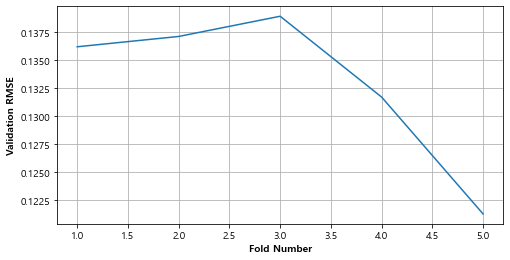

In [102]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(1, model_nmae.shape[0]+1), y=model_nmae)
plt.xlabel("Fold Number", weight='bold')
plt.ylabel("Validation RMSE", weight='bold')
plt.grid()
plt.show()

In [22]:
test_preds

array([[245.64920096],
       [752.697544  ],
       [153.93995163],
       ...,
       [371.75451596],
       [235.66131025],
       [ 95.58541957]])

In [40]:
submission_df = pd.read_csv("./data/sample_submission.csv")
submission_df['착과량(int)']=cb_preds
submission_df.to_csv('./submit/submission_cat_1213_11.csv', index=False)

In [41]:
submission_df

,ID,착과량(int)
0,TEST_0000,238.999041
1,TEST_0001,752.801088
2,TEST_0002,156.392673
3,TEST_0003,436.093492
4,TEST_0004,698.617026
...,...,...
2203,TEST_2203,758.257490
2204,TEST_2204,331.428288
2205,TEST_2205,353.981836
2206,TEST_2206,246.605085


# 세번째 모델 (best score)
ngboost가 데이터가 적은 task에선 좋은 성능을 보인다. 채택

In [24]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE

In [42]:
ngb = NGBRegressor(random_state = 2020)

In [37]:
ngb  = NGBRegressor(n_estimators=20000,  natural_gradient=True, learning_rate = 0.01,Base=default_tree_learner, Score=MLE, verbose_eval =50,random_state=1998)

kf = KFold(n_splits = 5, shuffle=True, random_state=0)

ngb_pred_1 = np.zeros((X_test.shape[0]))
nmae_list = []
for tr_idx, val_idx in kf.split(X_train):
    tr_x, val_x = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    tr_y, val_y = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    nmae = NMAE(val_y, pred)
    nmae_list.append(nmae)
    print(f'FOLD NMAE = {nmae}')
    sub_pred = ngb.predict(X_test) / 5
    ngb_pred_1 += sub_pred
print(f'\n{ngb.__class__.__name__} NMAE = {np.mean(nmae_list)}')

[iter 0] loss=6.8154 val_loss=6.7901 scale=1.0000 norm=190.8041
[iter 50] loss=6.1749 val_loss=6.1574 scale=2.0000 norm=151.9443
[iter 100] loss=5.7305 val_loss=5.7146 scale=2.0000 norm=75.9003
[iter 150] loss=5.3727 val_loss=5.3572 scale=2.0000 norm=60.9132
[iter 200] loss=5.1339 val_loss=5.1213 scale=2.0000 norm=58.3054
[iter 250] loss=5.0080 val_loss=5.0089 scale=2.0000 norm=57.6330
[iter 300] loss=4.9542 val_loss=4.9755 scale=2.0000 norm=57.2816
[iter 350] loss=4.9283 val_loss=4.9702 scale=2.0000 norm=57.0561
[iter 400] loss=4.9130 val_loss=4.9740 scale=2.0000 norm=56.8853
[iter 450] loss=4.9058 val_loss=4.9856 scale=2.0000 norm=56.7574
[iter 500] loss=4.9000 val_loss=5.0019 scale=2.0000 norm=56.6485
[iter 550] loss=4.8940 val_loss=5.0263 scale=1.0000 norm=28.2823
[iter 600] loss=4.8886 val_loss=5.0677 scale=2.0000 norm=56.4584
[iter 650] loss=4.8834 val_loss=5.1218 scale=2.0000 norm=56.3531
[iter 700] loss=4.8792 val_loss=5.1879 scale=2.0000 norm=56.2549
[iter 750] loss=4.8759 val

overflow encountered in exp
overflow encountered in square


[iter 0] loss=5.9817 val_loss=4.8539 scale=0.5000 norm=14.5377
[iter 50] loss=4.8783 val_loss=4.8578 scale=0.2500 norm=6.9930
[iter 100] loss=4.8757 val_loss=4.8593 scale=0.0625 norm=1.7474
[iter 150] loss=4.8717 val_loss=4.8628 scale=1.0000 norm=27.9243
[iter 200] loss=4.8697 val_loss=4.8650 scale=0.0001 norm=0.0017
[iter 250] loss=4.8697 val_loss=4.8650 scale=0.0001 norm=0.0017
[iter 300] loss=4.8697 val_loss=4.8650 scale=0.0001 norm=0.0017
[iter 350] loss=4.8697 val_loss=4.8650 scale=0.0001 norm=0.0017
[iter 400] loss=4.8697 val_loss=4.8650 scale=0.0001 norm=0.0017
[iter 450] loss=4.8697 val_loss=4.8650 scale=0.0001 norm=0.0017
[iter 500] loss=4.8697 val_loss=4.8650 scale=0.0001 norm=0.0017
[iter 550] loss=4.8697 val_loss=4.8650 scale=0.0001 norm=0.0017
[iter 600] loss=4.8697 val_loss=4.8650 scale=0.0001 norm=0.0017
[iter 650] loss=4.8697 val_loss=4.8650 scale=0.0001 norm=0.0017
[iter 700] loss=4.8697 val_loss=4.8650 scale=0.0001 norm=0.0017
[iter 750] loss=4.8697 val_loss=4.8650 sc

overflow encountered in exp
overflow encountered in square


[iter 0] loss=406.0002 val_loss=4.8333 scale=0.0010 norm=0.4189
[iter 50] loss=4.8617 val_loss=4.8316 scale=1.0000 norm=27.7343
[iter 100] loss=4.8533 val_loss=4.8361 scale=1.0000 norm=27.6239
[iter 150] loss=4.8488 val_loss=4.8409 scale=0.5000 norm=13.7730
[iter 200] loss=4.8462 val_loss=4.8451 scale=1.0000 norm=27.4890
[iter 250] loss=4.8435 val_loss=4.8500 scale=0.5000 norm=13.7234
[iter 300] loss=4.8414 val_loss=4.8540 scale=1.0000 norm=27.4147
[iter 350] loss=4.8391 val_loss=4.8581 scale=2.0000 norm=54.7517
[iter 400] loss=4.8375 val_loss=4.8612 scale=1.0000 norm=27.3491
[iter 450] loss=4.8366 val_loss=4.8632 scale=0.5000 norm=13.6670
[iter 500] loss=4.8361 val_loss=4.8648 scale=0.0020 norm=0.0534
[iter 550] loss=4.8361 val_loss=4.8648 scale=0.0010 norm=0.0267
[iter 600] loss=4.8361 val_loss=4.8648 scale=0.0005 norm=0.0133
[iter 650] loss=4.8361 val_loss=4.8648 scale=0.0002 norm=0.0067
[iter 700] loss=4.8361 val_loss=4.8648 scale=0.0002 norm=0.0067
[iter 750] loss=4.8361 val_loss=

In [200]:
model_ngb = NGBRegressor(n_estimators=20000,  natural_gradient=True, learning_rate = 0.01,Base=default_tree_learner, Score=MLE, verbose_eval =50,random_state=2022)
model_ngb.fit(X_train, y_train,X_val,y_val,early_stopping_rounds=1000)
Y_preds = model_ngb.predict(X_test)
Y_dists = model_ngb.pred_dist(X_test)

[iter 0] loss=6.9106 val_loss=6.9067 scale=1.0000 norm=215.8437
[iter 50] loss=6.2661 val_loss=6.2621 scale=2.0000 norm=167.1019
[iter 100] loss=5.8035 val_loss=5.8055 scale=2.0000 norm=77.5152
[iter 150] loss=5.4103 val_loss=5.4274 scale=2.0000 norm=57.7698
[iter 200] loss=5.1189 val_loss=5.1657 scale=2.0000 norm=54.0734
[iter 250] loss=4.9461 val_loss=5.0357 scale=2.0000 norm=52.9645
[iter 300] loss=4.8606 val_loss=4.9898 scale=2.0000 norm=52.1091
[iter 350] loss=4.8173 val_loss=4.9811 scale=2.0000 norm=51.4942
[iter 400] loss=4.7941 val_loss=4.9808 scale=2.0000 norm=51.0321
[iter 450] loss=4.7774 val_loss=4.9819 scale=2.0000 norm=50.6582
[iter 500] loss=4.7666 val_loss=4.9833 scale=1.0000 norm=25.1678
[iter 550] loss=4.7553 val_loss=4.9847 scale=2.0000 norm=50.0164
[iter 600] loss=4.7448 val_loss=4.9879 scale=1.0000 norm=24.8638
[iter 650] loss=4.7347 val_loss=4.9910 scale=2.0000 norm=49.4469
[iter 700] loss=4.7262 val_loss=4.9950 scale=1.0000 norm=24.5955
[iter 750] loss=4.7173 val

In [203]:
ngb_preds = model_ngb.predict(X_val)

# calculate mean squared error on val sub-set preds
nmae=NMAE(y_val,ngb_preds) # nmae 계산

print(f'모델 NMAE: {nmae}')
#np.sqrt(mean_squared_error(cb_preds, y_val))

모델 NMAE: 0.0643348812997023


In [204]:
ngb_preds=model_ngb.predict(X_test)

In [205]:
submission_df = pd.read_csv("./data/sample_submission.csv")
submission_df['착과량(int)']=ngb_preds
submission_df.to_csv('./submit/submission_ngb_30.csv', index=False)

# 4번째 모델 Tapnet
튜닝을 하지 않았지만 딥러닝 모델은 성능이 좋지 않게 나옴 

In [102]:
X_train_v=X_train.values
y_train_v=y_train.values.reshape(-1,1)

In [103]:
X_val_v=X_val.values
y_val_v=y_val.values.reshape(-1,1)
X_test_v=X_test.values

In [209]:
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import roc_auc_score
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
class Nmae(Metric):
    def __init__(self):
        self._name = "nmae"
        self._maximize = False

    def __call__(self, true, pred):
        mae = np.mean(np.abs(true-pred))
        score = mae / np.mean(np.abs(true))
        return score


In [212]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)



Device used : cuda


In [213]:
unsupervised_model.fit(
    X_train=X_train_v,
    eval_set=[X_val_v],
    max_epochs=200 , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
) 


epoch 0  | loss: 5.13237 | val_0_unsup_loss_numpy: 3.0429399013519287|  0:00:00s
epoch 5  | loss: 0.70159 | val_0_unsup_loss_numpy: 1.804710030555725|  0:00:01s

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.0621099472045898


Best weights from best epoch are automatically used!


In [108]:
reconstructed_X, embedded_X = unsupervised_model.predict(X_val_v)
assert(reconstructed_X.shape==embedded_X.shape)

In [109]:

unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_val_v)

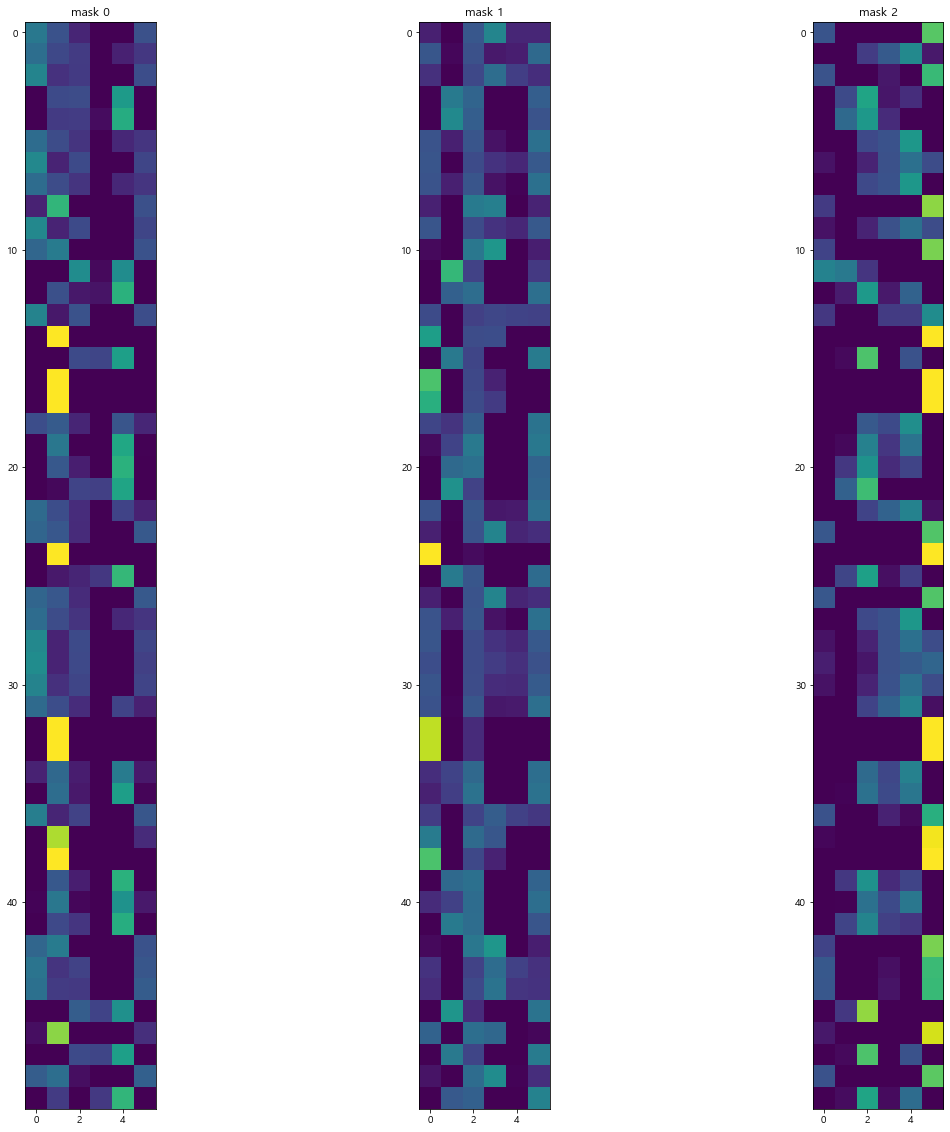

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [111]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')


Successfully saved model at ./test_pretrain.zip


Device used : cuda


In [112]:
clf = TabNetRegressor(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # This will be overwritten if using pretrain model
                       verbose=5,
                      )


In [113]:

clf.fit(
    X_train=X_train_v, y_train=y_train_v,
    eval_set=[(X_train_v, y_train_v), (X_val_v, y_val_v)],
    eval_name=['train', 'valid'],
    eval_metric=[Nmae],
    max_epochs=300 , patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    #weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain,
    
) 


Loading weights from unsupervised pretraining


epoch 0  | loss: 212356.55634| train_nmae: 0.99529 | valid_nmae: 0.996   |  0:00:00s
epoch 5  | loss: 211610.79435| train_nmae: 0.99025 | valid_nmae: 0.99078 |  0:00:01s
epoch 10 | loss: 210914.579| train_nmae: 0.99209 | valid_nmae: 0.9934  |  0:00:03s
epoch 15 | loss: 210287.46427| train_nmae: 0.99476 | valid_nmae: 0.99584 |  0:00:04s
epoch 20 | loss: 209689.46825| train_nmae: 0.99519 | valid_nmae: 0.99571 |  0:00:05s
epoch 25 | loss: 209109.36213| train_nmae: 0.99297 | valid_nmae: 0.99374 |  0:00:07s
epoch 30 | loss: 208504.12594| train_nmae: 0.98987 | valid_nmae: 0.99089 |  0:00:08s
epoch 35 | loss: 207995.2823| train_nmae: 0.98568 | valid_nmae: 0.98713 |  0:00:10s
epoch 40 | loss: 207493.90947| train_nmae: 0.98435 | valid_nmae: 0.98635 |  0:00:11s
epoch 45 | loss: 207053.03543| train_nmae: 0.9843  | valid_nmae: 0.98584 |  0:00:13s
epoch 50 | loss: 206583.80237| train_nmae: 0.98245 | valid_nmae: 0.98359 |  0:00:14s
epoch 55 | loss: 206169.23598| train_nmae: 0.98133 | valid_nmae: 0.9

Best weights from best epoch are automatically used!


In [214]:

from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)


In [215]:
clf =   TabNetRegressor()
clf.fit(
    X_train=X_train_v, y_train=y_train_v,
    eval_set=[(X_train_v, y_train_v), (X_val_v, y_val_v)],
    eval_name=['train', 'valid'],
    eval_metric=[Nmae],
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    augmentations=aug, #aug
) 

Device used : cuda


epoch 0  | loss: 209382.06451| train_nmae: 0.99647 | valid_nmae: 0.99734 |  0:00:00s
epoch 1  | loss: 208543.6183| train_nmae: 0.9897  | valid_nmae: 0.99165 |  0:00:00s
epoch 2  | loss: 207563.23053| train_nmae: 0.99297 | valid_nmae: 0.99293 |  0:00:01s
epoch 3  | loss: 204279.74578| train_nmae: 0.99031 | valid_nmae: 0.99025 |  0:00:01s
epoch 4  | loss: 204731.43618| train_nmae: 0.98291 | valid_nmae: 0.98328 |  0:00:01s
epoch 5  | loss: 203014.23507| train_nmae: 0.97801 | valid_nmae: 0.97836 |  0:00:01s
epoch 6  | loss: 201396.90278| train_nmae: 0.97143 | valid_nmae: 0.97074 |  0:00:02s
epoch 7  | loss: 199866.98329| train_nmae: 0.96686 | valid_nmae: 0.96643 |  0:00:02s
epoch 8  | loss: 198359.05178| train_nmae: 0.96522 | valid_nmae: 0.96572 |  0:00:02s
epoch 9  | loss: 197108.42066| train_nmae: 0.96122 | valid_nmae: 0.96198 |  0:00:03s
epoch 10 | loss: 195034.41486| train_nmae: 0.95518 | valid_nmae: 0.95562 |  0:00:03s
epoch 11 | loss: 192426.23013| train_nmae: 0.95025 | valid_nmae: 0

epoch 98 | loss: 2401.01389| train_nmae: 0.3091  | valid_nmae: 0.34507 |  0:00:31s
epoch 99 | loss: 2336.18748| train_nmae: 0.32081 | valid_nmae: 0.29897 |  0:00:32s
Stop training because you reached max_epochs = 100 with best_epoch = 83 and best_valid_nmae = 0.22749


Best weights from best epoch are automatically used!


In [218]:
preds = clf.predict(X_val_v)

y_true = y_val_v

test_score = NMAE(y_true,preds)

print(f"BEST VALID SCORE FOR 테스트 : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR 테스트 : {test_score}")

BEST VALID SCORE FOR 테스트 : 0.22748806667683455
FINAL TEST SCORE FOR 테스트 : 0.0895516855627651


In [118]:
preds.min(),preds.max(),preds.mean()

(-0.57817143, 791.81445, 378.7487)

In [117]:
preds = clf.predict(X_test_v)

In [259]:
submission_df['착과량(int)']=preds

In [260]:
submission_df['착과량(int)']=submission_df['착과량(int)'].apply(lambda x: 0 if x < 0 else x)

In [268]:
submission_df.to_csv('./submit/submission_tabnet_feature.csv', index=False)

In [ ]:
Preds = clf.predict(X_val_v)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_score}")

## Submission ensemble

단일 ngb 성능이 가장 높게 나온 모델과 oversampling을 진행하지 않고 파생변수를 추가해 학습시킨 ngb 모델과 앙상블 진행

Pubilc score 1위

In [ ]:
submission_df = pd.read_csv("./data/sample_submission.csv")
submission_df['착과량(int)']=(ngb['착과량(int)']+cat['착과량(int)'])/2
submission_df.to_csv('./submit/submission_ngbcat_two.csv', index=False)

In [ ]:
#best 11등
submission_df = pd.read_csv("./data/sample_submission.csv")
seong=pd.read_csv('./submit/1213_v5.csv')
ngb_best = pd.read_csv("./submit/submission_ngbover2.csv")
submission_df['착과량(int)']=(seong['착과량(int)']+ngb_best['착과량(int)'])/2
submission_df.to_csv('./submit/submission_seong_ngb.csv', index=False)

#best 우리 1등
submission_df['착과량(int)']=(ngb_best['착과량(int)']*0.6+seong['착과량(int)']*0.4)

In [ ]:
#best 성규 11등
submission_df = pd.read_csv("./data/sample_submission.csv")
seong=pd.read_csv('./submit/1213_v5.csv')
ngb_best = pd.read_csv("./submit/submission_ngb_27.csv")
#submission_df['착과량(int)']=(seong['착과량(int)']+ngb_best['착과량(int)'])/2

#best 우리 9등
submission_df['착과량(int)']=(ngb_best['착과량(int)']*0.65+seong['착과량(int)']*0.35)
submission_df.to_csv('./submit/submission_6,5_27.csv', index=False)
